In [1]:
def get_color_histogram(img, n_bins=32, bins_range=(0, 256)):
    red_hist = np.histogram(img[:,:,0], bins=n_bins, range=bins_range)
    green_hist = np.histogram(img[:,:,1], bins=n_bins, range=bins_range)
    blue_hist = np.histogram(img[:,:,2], bins=n_bins, range=bins_range)
    bin_edges = red_hist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    hist_features = np.concatenate((red_hist[0], 
                                    green_hist[0], 
                                    blue_hist[0]))
    return red_hist, green_hist, blue_hist, bin_centers, hist_features

def get_3d_color_plot(pixels, colors_rgb,
                      axis_labels=list("RGB"),
                      axis_limits=[(0, 255), (0, 255), (0, 255)]):
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)  
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')
    return ax

def get_bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    features = cv2.resize(feature_image, size).ravel() 
    return features

def get_gradient_features(img, sobel_kernel=9, mag_threshold=(60, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_threshold[0]) & 
                  (gradmag <= mag_threshold[1])] = 1
    return binary_output

def get_hog_features(img, 
                     orientation=9, 
                     pixels_per_cell=(8,8), 
                     cells_per_block=(2,2), 
                     visualization=False, 
                     feature_vector=True):
    if visualization == True:
        features, hog_image = hog(img, orientations=orientation, 
                                  pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block, 
                                  transform_sqrt=False,
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:
        features = hog(img, orientations=orientation, 
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, 
                       transform_sqrt=False,
                       visualise=False, feature_vector=feature_vector) 
        return features
    
def extract_features(images, color_space='RGB', 
                     spatial_size=(32,32), 
                     hist_bins=32, hist_range=(0,256),
                     orientations=9, pixels_per_cell=(8,8),
                     cells_per_block=(2,2), hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in tqdm(images):
        file_features = []
        img = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(img)      
        
        if spatial_feat == True:
            spatial_features = get_bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            red_hist, green_hist, blue_hist, bin_centers, hist_features = get_color_histogram(feature_image, n_bins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                         orientations, pixels_per_cell, 
                                                         cells_per_block, visualization=False,
                                                         feature_vector=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                orientations, pixels_per_cell,
                                                cells_per_block, visualization=False,
                                                feature_vector=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))      
    return features

print("functions built")

functions built


In [2]:
#load data
import glob
from random import shuffle

cars = glob.glob('x:/XCar/detection_data/vehicles/**/*.png', recursive=True)
notcars = glob.glob('x:/XCar/detection_data/non-vehicles/**/*.png', recursive=True)

print('len(cars)', len(cars))
print('len(notcars)', len(notcars))
print(cars[1])
    
print(cars[0:4])

shuffle(cars)
shuffle(notcars)
print("shuffled")

len(cars) 8792
len(notcars) 8968
x:/XCar/detection_data/vehicles\GTI_Far\image0001.png
['x:/XCar/detection_data/vehicles\\GTI_Far\\image0000.png', 'x:/XCar/detection_data/vehicles\\GTI_Far\\image0001.png', 'x:/XCar/detection_data/vehicles\\GTI_Far\\image0002.png', 'x:/XCar/detection_data/vehicles\\GTI_Far\\image0003.png']
shuffled


In [3]:
import numpy as np

import cv2

import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from skimage.feature import hog

from sklearn.preprocessing import StandardScaler

# from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC

from scipy.ndimage.measurements import label

import pickle
import os

import time

import math

from tqdm import tqdm

veh_features = extract_features(cars, spatial_feat=True, hist_feat=True)
not_veh_features = extract_features(notcars, spatial_feat=True, hist_feat=True)



100%|██████████| 8968/8968 [02:54<00:00, 51.41it/s]


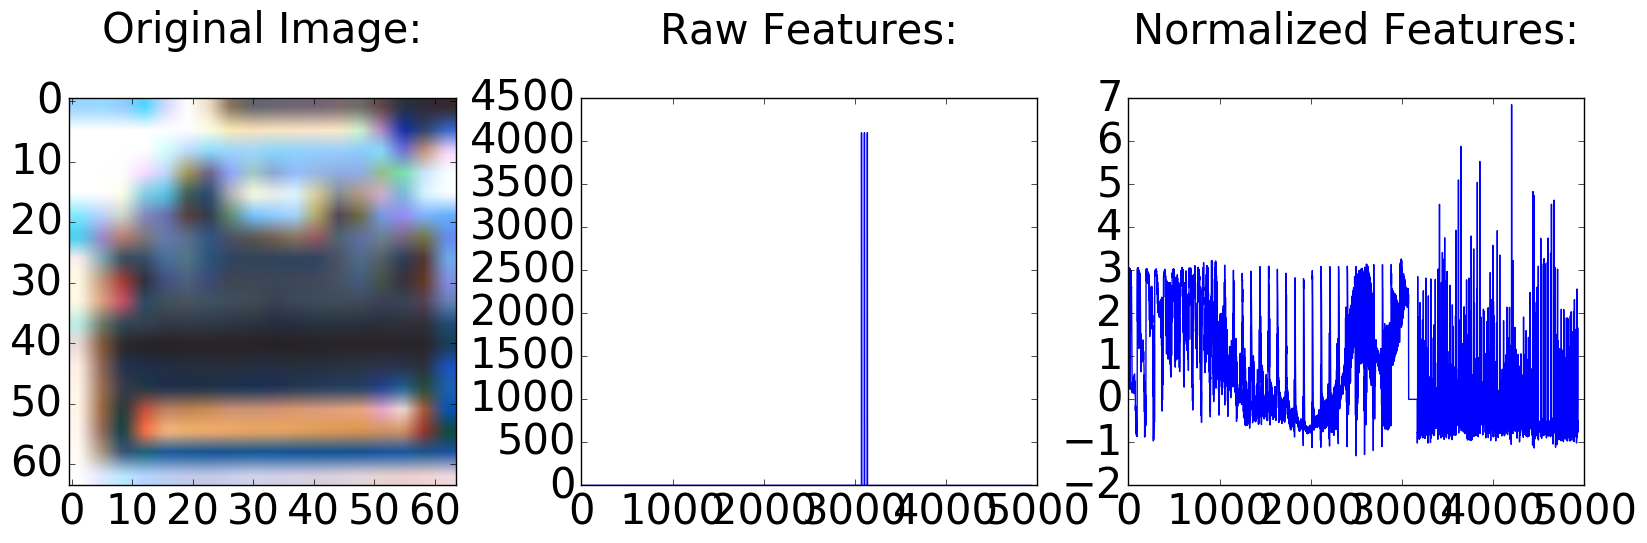

In [4]:
if len(veh_features) > 0:
    X = np.vstack((veh_features, not_veh_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    
    f = plt.figure(figsize=(20, 5))
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)
    
    car_id = np.random.randint(0, len(cars))
    
    plt.subplot(1, 3, 1)
    plt.imshow(mpimg.imread(cars[car_id]))
    plt.title('Original Image:\n', fontsize=30)
    plt.subplot(1, 3, 2)
    plt.plot(X[car_id])
    plt.title('Raw Features:\n', fontsize=30)
    plt.subplot(1, 3, 3)
    plt.plot(scaled_X[car_id])
    plt.title('Normalized Features:\n', fontsize=30)
    plt.savefig('output_images/color_classification.png')

else:
    print('Returned empty feature vectors.')

In [5]:
y = np.hstack((np.ones(len(veh_features)), np.zeros(len(not_veh_features))))

X = np.vstack((veh_features, not_veh_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

from sklearn.preprocessing import StandardScaler

# from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC

from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split

# print ("scaled_X.shape:",scaled_X.shape)
# print ("y.shape:",y.shape)

rand_state = np.random.randint(0, 10)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2,random_state=rand_state)

print("Done")

Done


In [6]:
#train svc
#LinearSVC model
svc = LinearSVC(C=0.01)
t=time.time()
print("fitting")
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')

fitting
42.14 seconds to train SVC.


In [7]:
print('Test Accuracy: {0:0.4f}%'.format(svc.score(X_test, y_test)*100))
print('  Predictions:', svc.predict(X_test[0:10]))
print('       Labels:', y_test[0:10])

Test Accuracy: 97.4381%
  Predictions: [ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.]
       Labels: [ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.]


100%|██████████| 8968/8968 [04:03<00:00, 36.80it/s]


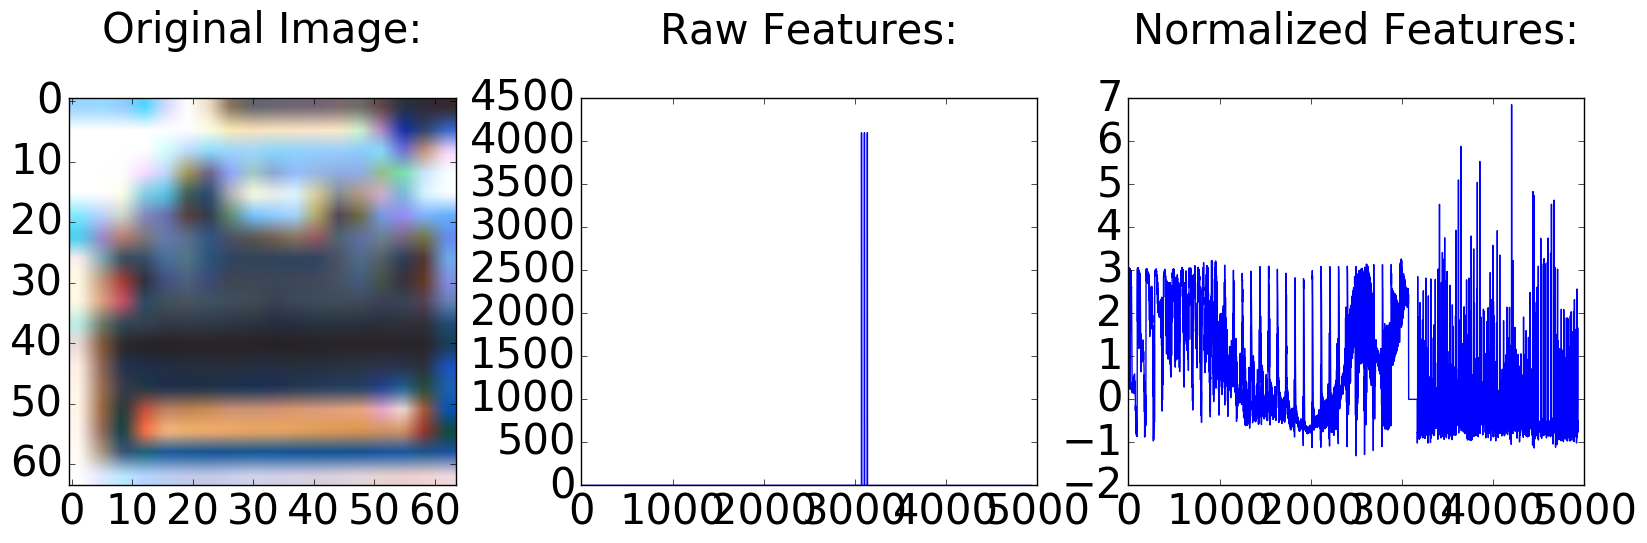

In [8]:
#classifier with hog features

veh_features = extract_features(cars, hog_feat=True)
not_veh_features = extract_features(notcars, hog_feat=True)

if len(veh_features) > 0:
    X = np.vstack((veh_features, not_veh_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    
    f = plt.figure(figsize=(20, 5))
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)

    plt.subplot(1, 3, 1)
    plt.imshow(mpimg.imread(cars[car_id]))
    plt.title('Original Image:\n', fontsize=30)
    plt.subplot(1, 3, 2)
    plt.plot(X[car_id])
    plt.title('Raw Features:\n', fontsize=30)
    plt.subplot(1, 3, 3)
    plt.plot(scaled_X[car_id])
    plt.title('Normalized Features:\n', fontsize=30)
    plt.savefig('output_images/hog_classification.png')

else:
    print('Returned empty feature vectors.')

In [9]:
y = np.hstack((np.ones(len(veh_features)), np.zeros(len(not_veh_features))))

X = np.vstack((veh_features, not_veh_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
rand_state = np.random.randint(0, 10)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2,random_state=rand_state)
svc = LinearSVC(C=0.01)
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')



103.61 seconds to train SVC.


In [10]:
print('Test Accuracy: {0:0.4f}%'.format(svc.score(X_test, y_test)*100))
t = time.time()
print('  Predictions:', svc.predict(X_test[0:10]))
print('       Labels:', y_test[0:10])
t2 = time.time()
print(round(t2-t, 5), 'seconds to predict 10 labels with SVC.')

Test Accuracy: 97.1284%
  Predictions: [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  0.]
       Labels: [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  0.]
0.31587 seconds to predict 10 labels with SVC.


## Detection

In [11]:
def draw_boxes(img, bboxes, color=(0,0,255), thickness=6):
    img_copy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(img_copy, bbox[0], bbox[1], 
                      color, thickness)
    return img_copy

def sliding_windows(img, x_start_stop=[None,None], 
                    y_start_stop=[None,None], xy_window=(64,64),
                    xy_overlap=(0.5,0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = int(img.shape[0]*0.45)
    if y_start_stop[1] == None:
        y_start_stop[1] = int(img.shape[0]*0.9)
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list


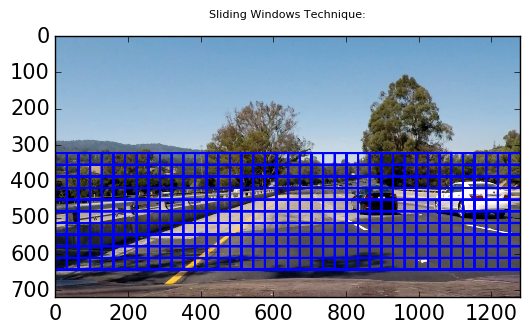

In [13]:
test_img = mpimg.imread('test_images/test4.jpg')

windows =  sliding_windows(test_img)

window_img = draw_boxes(test_img, windows)
plt.imshow(window_img);
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8)
plt.title('Sliding Windows Technique:\n', fontsize=8);
plt.savefig('output_images/sliding_windows_test4.png')

In [15]:
def single_img_features(img, color_space='RGB', 
                        spatial_size=(64,64), hist_bins=64, 
                        orientations=9, pixels_per_cell=(8,8), 
                        cells_per_block=(2,2), hog_channel=0, 
                        spatial_feat=True, hist_feat=True, 
                        hog_feat=True):
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)  
    if spatial_feat == True:
        spatial_features = get_bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        red_hist, green_hist, blue_hist, bin_centers, hist_features = get_color_histogram(feature_image, n_bins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                                     orientations, pixels_per_cell,
                                                     cells_per_block, 
                                                     visualization=False,
                                                     feature_vector=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                            orientations, pixels_per_cell,
                                            cells_per_block, visualization=False,
                                            feature_vector=True)
        img_features.append(hog_features)
    return np.concatenate(img_features)

def search_windows(img, windows, svc, scaler, 
                   color_space='RGB', spatial_size=(64,64), 
                   hist_bins=64, hist_range=(0,256), orientations=9,
                   pixels_per_cell=(8,8), cells_per_block=(2,2),
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orientations=orientations, pixels_per_cell=pixels_per_cell, 
                            cells_per_block=cells_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = svc.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows



In [16]:
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orientations = 9  # HOG orientations
pixels_per_cell = (16,16) # HOG pixels per cell
cells_per_block = (4,4) # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16 # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

veh_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orientations=orientations, pixels_per_cell=pixels_per_cell, 
                        cells_per_block=cells_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
not_veh_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orientations=orientations, pixels_per_cell=pixels_per_cell, 
                        cells_per_block=cells_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)



100%|██████████| 8968/8968 [04:27<00:00, 33.53it/s]


Using: 9 orientations (16, 16) pixels per cell and (4, 4) cells per block
Feature vector length: 1248
5.06  seconds to train SVC.
Test Accuracy of SVC: 98.2264%


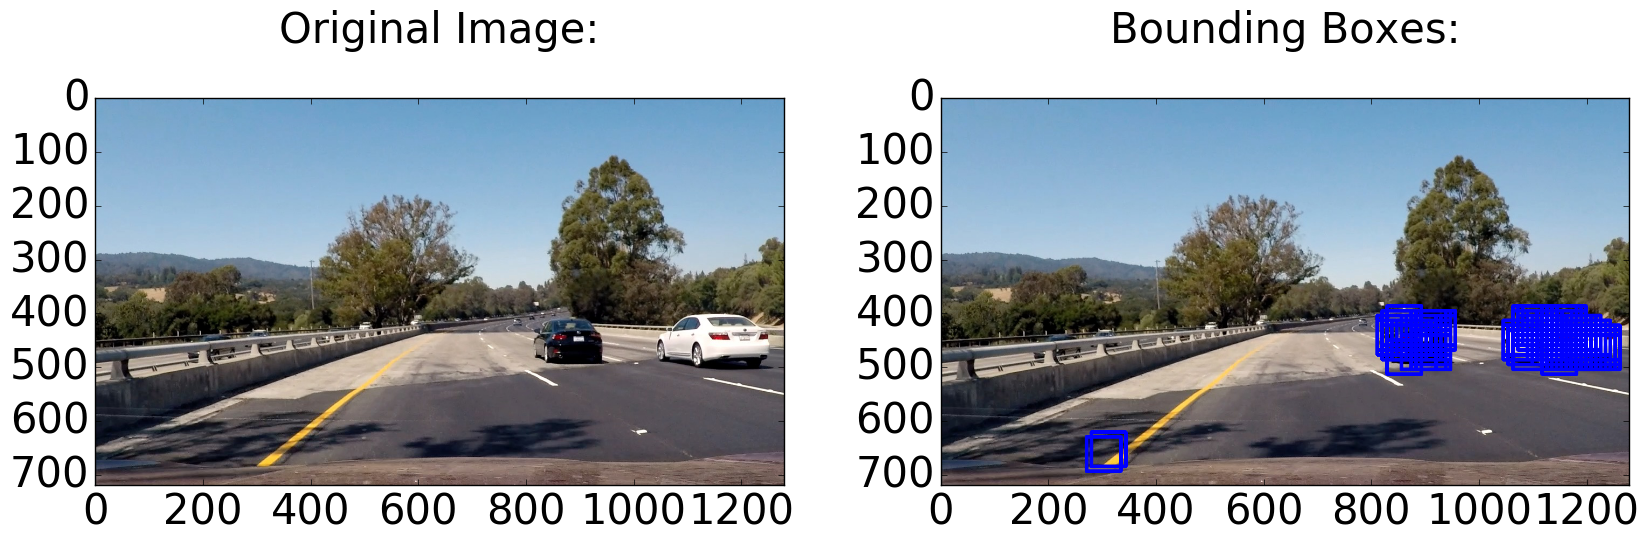

In [17]:
X = np.vstack((veh_features, not_veh_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(veh_features)), np.zeros(len(not_veh_features))))

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2)

print('Using:', orientations, 'orientations', pixels_per_cell,
    'pixels per cell and', cells_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC(C=0.01)
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), ' seconds to train SVC.')
print('Test Accuracy of SVC: {0}%'.format(round(svc.score(X_test, y_test)*100, 4)))
t=time.time()

img = mpimg.imread('test_images/test4.jpg')
draw_img = np.copy(img)

# Training Data extracted from .png images (scaled 0 to 1 by mpimg)
# Search image is a .jpg (scaled 0 to 255)
img = img.astype(np.float32)/255

windows = sliding_windows(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85))

hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orientations=orientations, pixels_per_cell=pixels_per_cell, 
                        cells_per_block=cells_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_img, hot_windows)                    

f = plt.figure(figsize=(20, 5))
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image:\n', fontsize=30);
plt.subplot(1, 2, 2)
plt.imshow(window_img)
plt.title('Bounding Boxes:\n', fontsize=30);

bbox_pickle = {}
all_bboxes = hot_windows
bbox_pickle["bboxes"] = all_bboxes
pickle.dump(bbox_pickle, open("output_images/bbox_pickle.p", "wb"));

plt.savefig('output_images/all_window_detections.png')

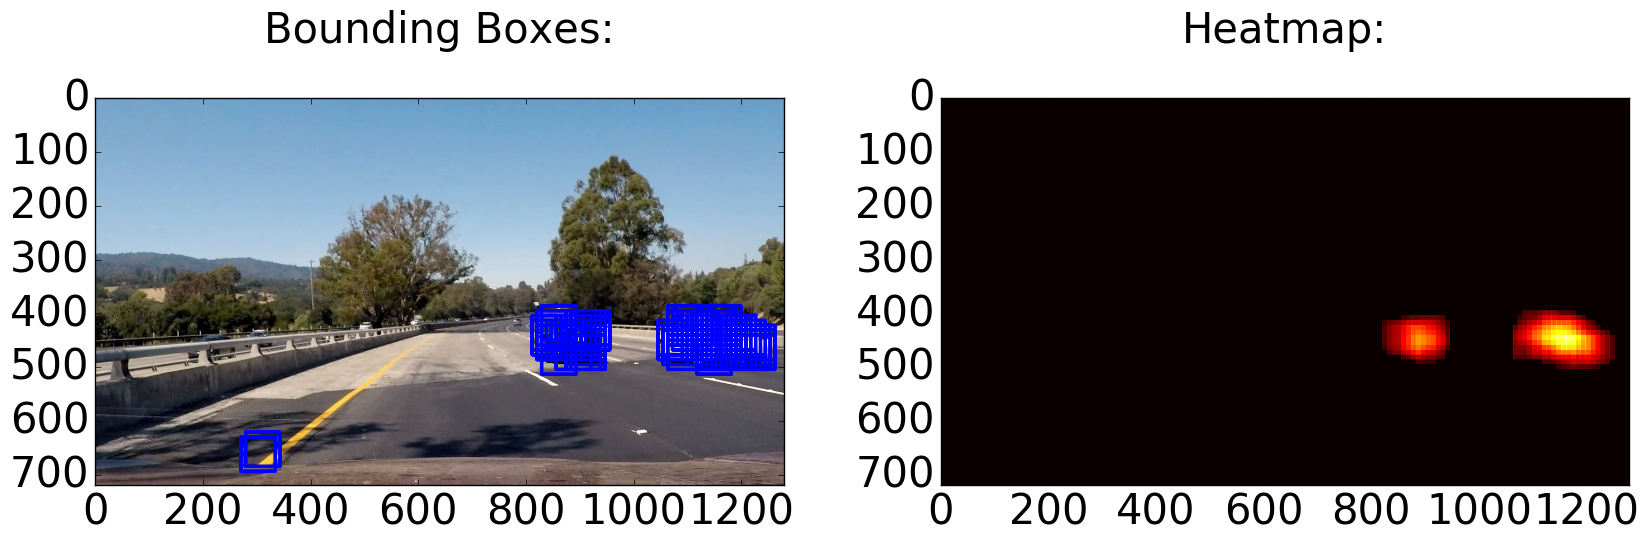

In [18]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
 
def apply_heat_threshold(heatmap, threshold=4):
    heatmap[heatmap <= threshold] = 0
    return heatmap

bbdict = pickle.load( open( "output_images/bbox_pickle.p", "rb" ))
all_bboxes = bbox_pickle["bboxes"]

img = mpimg.imread('test_images/test4.jpg')
#img = undistort(img)
heatmap = np.zeros_like(img[:,:,0].astype(np.float))

heatmap = add_heat(heatmap, all_bboxes)
heatmap = apply_heat_threshold(heatmap)
heatmap = np.clip(heatmap-2, 0, 255)

labels = label(heatmap)

#print('Cars Found: {0}'.format(labels[1]))

f = plt.figure(figsize=(20, 5))
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)

plt.subplot(1, 2, 1)
plt.imshow(window_img)
plt.title('Bounding Boxes:\n', fontsize=30);
plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='hot')
plt.title('Heatmap:\n', fontsize=30);
plt.savefig('output_images/heatmap.png')

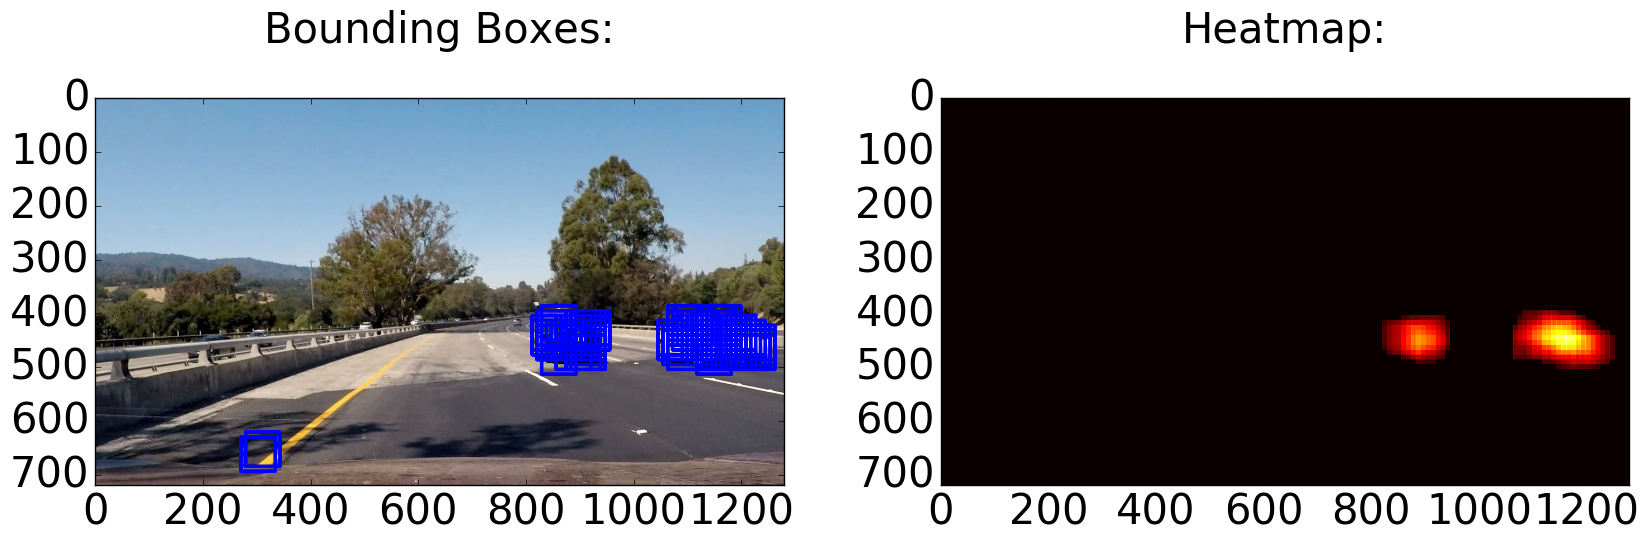

In [19]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
 
def apply_heat_threshold(heatmap, threshold=4):
    heatmap[heatmap <= threshold] = 0
    return heatmap

bbdict = pickle.load( open( "output_images/bbox_pickle.p", "rb" ))
all_bboxes = bbox_pickle["bboxes"]

img = mpimg.imread('test_images/test4.jpg')
#img = undistort(img)
heatmap = np.zeros_like(img[:,:,0].astype(np.float))

heatmap = add_heat(heatmap, all_bboxes)
heatmap = apply_heat_threshold(heatmap)
heatmap = np.clip(heatmap-2, 0, 255)

labels = label(heatmap)

#print('Cars Found: {0}'.format(labels[1]))

f = plt.figure(figsize=(20, 5))
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)

plt.subplot(1, 2, 1)
plt.imshow(window_img)
plt.title('Bounding Boxes:\n', fontsize=30);
plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='hot')
plt.title('Heatmap:\n', fontsize=30);
plt.savefig('output_images/heatmap.png')

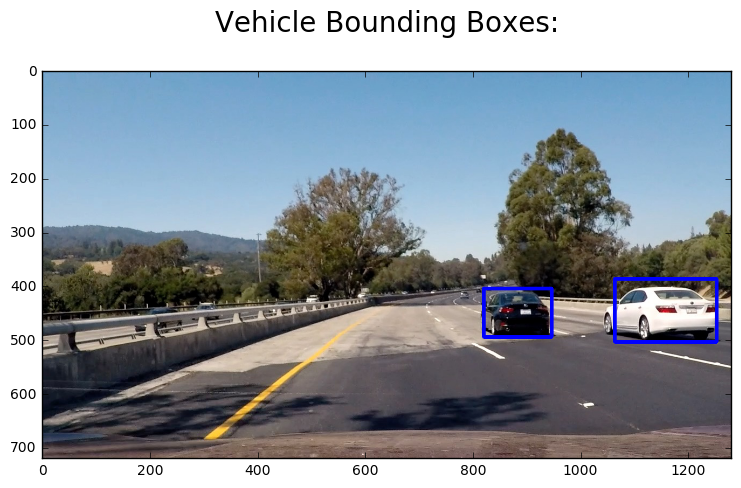

In [29]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

img = mpimg.imread('test_images/test4.jpg')
draw_img = np.copy(img)
draw_img = draw_labeled_bboxes(draw_img, labels)

f = plt.figure(figsize=(20, 5))
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
plt.imshow(draw_img)
plt.title('Vehicle Bounding Boxes:\n', fontsize=20);

In [30]:
def BGRtoYUV(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

orientations = 8
pixels_per_cell = 8
cells_per_block = 2

def hog_features(channel, visualise=False):
    if visualise == True:
        features, hog_image = hog(channel, orientations=orientations,
                                  pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                                  cells_per_block=(cells_per_block, cells_per_block),
                                  transform_sqrt=False, visualise=True, feature_vector=False)
        return hog_image
    else:      
        features = hog(channel, orientations=orientations,
                       pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                       cells_per_block=(cells_per_block, cells_per_block),
                       transform_sqrt=False, visualise=False, feature_vector=True)
        return features

def derive_features(img):
    img = BGRtoYUV(img)
    features_y = hog_features(img[:,:,0])
    features_u = hog_features(img[:,:,1])
    features_v = hog_features(img[:,:,2])
    return np.concatenate((features_y, features_u, features_v))

def search_windows(img, windows, clf, scaler):
    # Create a list to hold the positive detections.
    on_windows = []
    
    # Iterate over all the windows in the list.
    for window in windows:
        # Extract the window image from the original image.
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # Convert to the expected BGR in feature extractor.
        window_img = cv2.cvtColor(window_img, cv2.COLOR_RGB2BGR)
        # Extract features for the resized window image
        features = derive_features(window_img)
        # Normalize the extracted features.
        features = scaler.transform(np.array(features).reshape(1, -1))
        # Save the window if prediction is positive.
        if clf.decision_function(features) > threshold:
            on_windows.append(window)
    
    # Return the windows with positive detections.
    return on_windows

In [21]:
input_images = []
y = []


for filename in tqdm(glob.glob(('x:/XCar/detection_data/vehicles/**/*.png'))):
    img = cv2.imread(filename)
    features = derive_features(img)
    input_images.append(features)
    y.append(True)

for filename in tqdm(glob.glob('x:/XCar/detection_data/non-vehicles/**/*.png')):
    img = cv2.imread(filename)
    features = derive_features(img)
    input_images.append(features)
    y.append(False)
    
len(input_images)

100%|██████████| 8968/8968 [00:57<00:00, 156.81it/s]


17760

In [22]:
X_scaler = StandardScaler().fit(input_images)
input_images = X_scaler.transform(input_images)

X_train, X_test, y_train, y_test = train_test_split(input_images, y, test_size=0.2, stratify=y, random_state=1)

classifier = LinearSVC(random_state=1)
classifier.fit(X_train, y_train)

print('Vehicle classifier trained with test accuracy: %.1f%%' % (100. * classifier.score(X_test, y_test)))

Vehicle classifier trained with test accuracy: 98.5%


In [31]:
WINDOW_SIZES = [(64, 64), (96, 96), (128, 128)]
WINDOW_Y_START_STOP = [(400, 500), (400, 500), (400, 500)]
WINDOW_OVERLAP = (0.8, 0.8)

# img is of RGB type
def slide_window(img):
    window_list = []
    
    for (xy_window, y_start_stop) in zip(WINDOW_SIZES, WINDOW_Y_START_STOP):
        x_start = int(img.shape[1]/2)
        x_stop = img.shape[1]
        y_start = y_start_stop[0]
        y_stop = y_start_stop[1]
    
        # Compute ROI.
        xspan = x_stop - x_start
        yspan = y_stop - y_start
        
        # Compute the step between successive windows.
        nx_pix_per_step = np.int(xy_window[0] * (1. - WINDOW_OVERLAP[0]))
        ny_pix_per_step = np.int(xy_window[1] * (1. - WINDOW_OVERLAP[1]))
        # Compute the number of windows to generate at this size.
        nx_windows = int(xspan/nx_pix_per_step) - 1
        ny_windows = int(yspan/ny_pix_per_step) - 1
        # Loop through the x and y positions to find the window coordinates.
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                startx = xs*nx_pix_per_step + x_start
                endx = startx + xy_window[0]
                starty = ys*nx_pix_per_step + y_start
                endy = starty + xy_window[1]
                window_list.append(((startx, starty), (endx, endy)))
                
    # Return the list of windows.
    return window_list

img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)
img = draw_boxes(img, windows)

In [32]:
threshold = 0.7

def search_windows(img, windows, clf, scaler):
    # Create a list to hold the positive detections.
    on_windows = []
    
    # Iterate over all the windows in the list.
    for window in windows:
        # Extract the window image from the original image.
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # Convert to the expected BGR in feature extractor.
        window_img = cv2.cvtColor(window_img, cv2.COLOR_RGB2BGR)
        # Extract features for the resized window image
        features = derive_features(window_img)
        # Normalize the extracted features.
        features = scaler.transform(np.array(features).reshape(1, -1))
        # Save the window if prediction is positive.
        if clf.decision_function(features) > threshold:
            on_windows.append(window)
    
    # Return the windows with positive detections.
    return on_windows

img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)
windows = search_windows(img, windows, classifier, X_scaler)
img = draw_boxes(img, windows)

In [33]:
HEATMAP_THRESHOLD = 2

def add_heat(heatmap, bboxes):
    # Iterate through each bbox.
    for bbox in bboxes:
        # Add +1 for all pixels inside each bbox.
        heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1
    # Return updated heatmap.
    return heatmap
    
def apply_threshold(heatmap):
    # Zero out pixels below the threshold.
    heatmap[heatmap <= HEATMAP_THRESHOLD] = 0
    # Return thresholded map.
    return heatmap

img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)
windows = search_windows(img, windows, classifier, X_scaler)
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, windows)
heatmap = apply_threshold(heatmap)

In [34]:
def draw_labeled_bboxes(img, heatmap):
    # Generate the labels from the heat map.
    labels = label(heatmap)
    # Keep a list of bboxes for detected vehicles.
    bboxes = []
    # Iterate through all detected vehicles.
    for vehicle in range(1, labels[1]+1):
        # Find pixels with each vehicle label value.
        nonzero = (labels[0] == vehicle).nonzero()
        # Identify x and y values of those pixels.
        nonzerox = np.array(nonzero[0])
        nonzeroy = np.array(nonzero[1])
        # Define a bounding box based on the min/max x and y.
        bbox = ((np.min(nonzeroy), np.min(nonzerox)), (np.max(nonzeroy), np.max(nonzerox)))
        bboxes.append(bbox)
    # Draw the bounding boxes for the detected vehicles.
    img = draw_boxes(img, bboxes)
    # Return the annotated image.
    return img

img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)
windows = search_windows(img, windows, classifier, X_scaler)
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, windows)
heatmap = apply_threshold(heatmap)
img = draw_labeled_bboxes(img, heatmap)

In [35]:
frame_count = 5

class VehicleDetector:
    def __init__(self):
        self.bboxes = []
    
    def add_bboxes(self, bboxes):
        self.bboxes.append(bboxes)
        self.bboxes = self.bboxes[-frame_count:]
    
    def heatmap(self):
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        for bboxes in self.bboxes:
            add_heat(heatmap, bboxes)
        heatmap = apply_threshold(heatmap)
        return heatmap

In [36]:
vehicle_detector = VehicleDetector()

def video_pipeline(img):
    
    #global vehicle_detector
    
    #if vehicle_detector is None:
        #vehicle_detector = VehicleDetector()
    windows = slide_window(img)
    windows = search_windows(img, windows, classifier, X_scaler)
    vehicle_detector.add_bboxes(windows)
    heatmap = vehicle_detector.heatmap()
    img = draw_labeled_bboxes(img, heatmap)
    return img

In [38]:
from moviepy.editor import VideoFileClip
video_output = 'output_test_video.mp4'
clip = VideoFileClip('test_video.mp4')

output_clip = clip.fl_image(video_pipeline) #color images only
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_test_video.mp4
[MoviePy] Writing video output_test_video.mp4


 97%|█████████▋| 38/39 [02:11<00:03,  3.44s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test_video.mp4 

Wall time: 2min 13s


In [ ]:
video_output = 'output_project_video_final.mp4'
clip = VideoFileClip('project_video.mp4')

output_clip = clip.fl_image(video_pipeline) #color images only
%time output_clip.write_videofile(video_output, audio=False)